In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
from params import *

In [67]:
# mode = 'compute'
mode = 'load'
savefig = True

In [48]:
def interesting_sel_patient(patient):
    da_tf_stretched = xr.load_dataarray(f'../dataarray/da_tf_stretched_{patient}.nc')
    cycles_spindled = np.load(f'../df_analyse/cycles_spindled_{patient}.npy')
    all_cycles = da_tf_stretched.coords['cycle'].values
    cycles_without_spindle = [c for c in all_cycles if not c in cycles_spindled]
    
    row = [patient, all_cycles.size , cycles_spindled.size, len(cycles_without_spindle)]
    df_cycles_numbers = pd.Series(data=row, index = ['patient', 'all', 'spindled', 'no_spindle'])
    df_cycles_numbers.to_excel(f'../df_analyse/cycles_numbers_{patient}.xlsx')
    
    tf_spindled = da_tf_stretched.loc[:,cycles_spindled,:,:].mean('cycle')
    tf_all = da_tf_stretched.mean('cycle')
    tf_no_spindle = da_tf_stretched.loc[:,cycles_without_spindle,:,:].mean('cycle')
    del da_tf_stretched
    tf_sel_patient = xr.concat( [tf_all, tf_spindled , tf_no_spindle] , dim = 'cycle_sel')
    tf_sel_patient = tf_sel_patient.assign_coords({'cycle_sel':['all','spindled','no_spindle']})
    return tf_sel_patient

In [61]:
def get_cycles_num(patient, mean):
    ser = pd.read_excel(f'../df_analyse/cycles_numbers_{patient}.xlsx', index_col = 0).T.set_index('patient')
    return ser.loc[patient, mean]

In [49]:
if mode == 'compute':
    concat = []
    for patient in patients:
        print(patient)
        concat.append(interesting_sel_patient(patient))
    tf_all_sel = xr.concat(concat, dim = 'patient')
    tf_all_sel = tf_all_sel.assign_coords({'patient':patients})
    # tf_all_sel.to_netcdf(f'../dataarray/tf_sel_mean.nc')
elif mode == 'load':
    tf_all_sel = xr.load_dataarray(f'../dataarray/tf_sel_mean.nc')

P1
P2
P3
P4
P5
P6
P7
P8
P9
P10


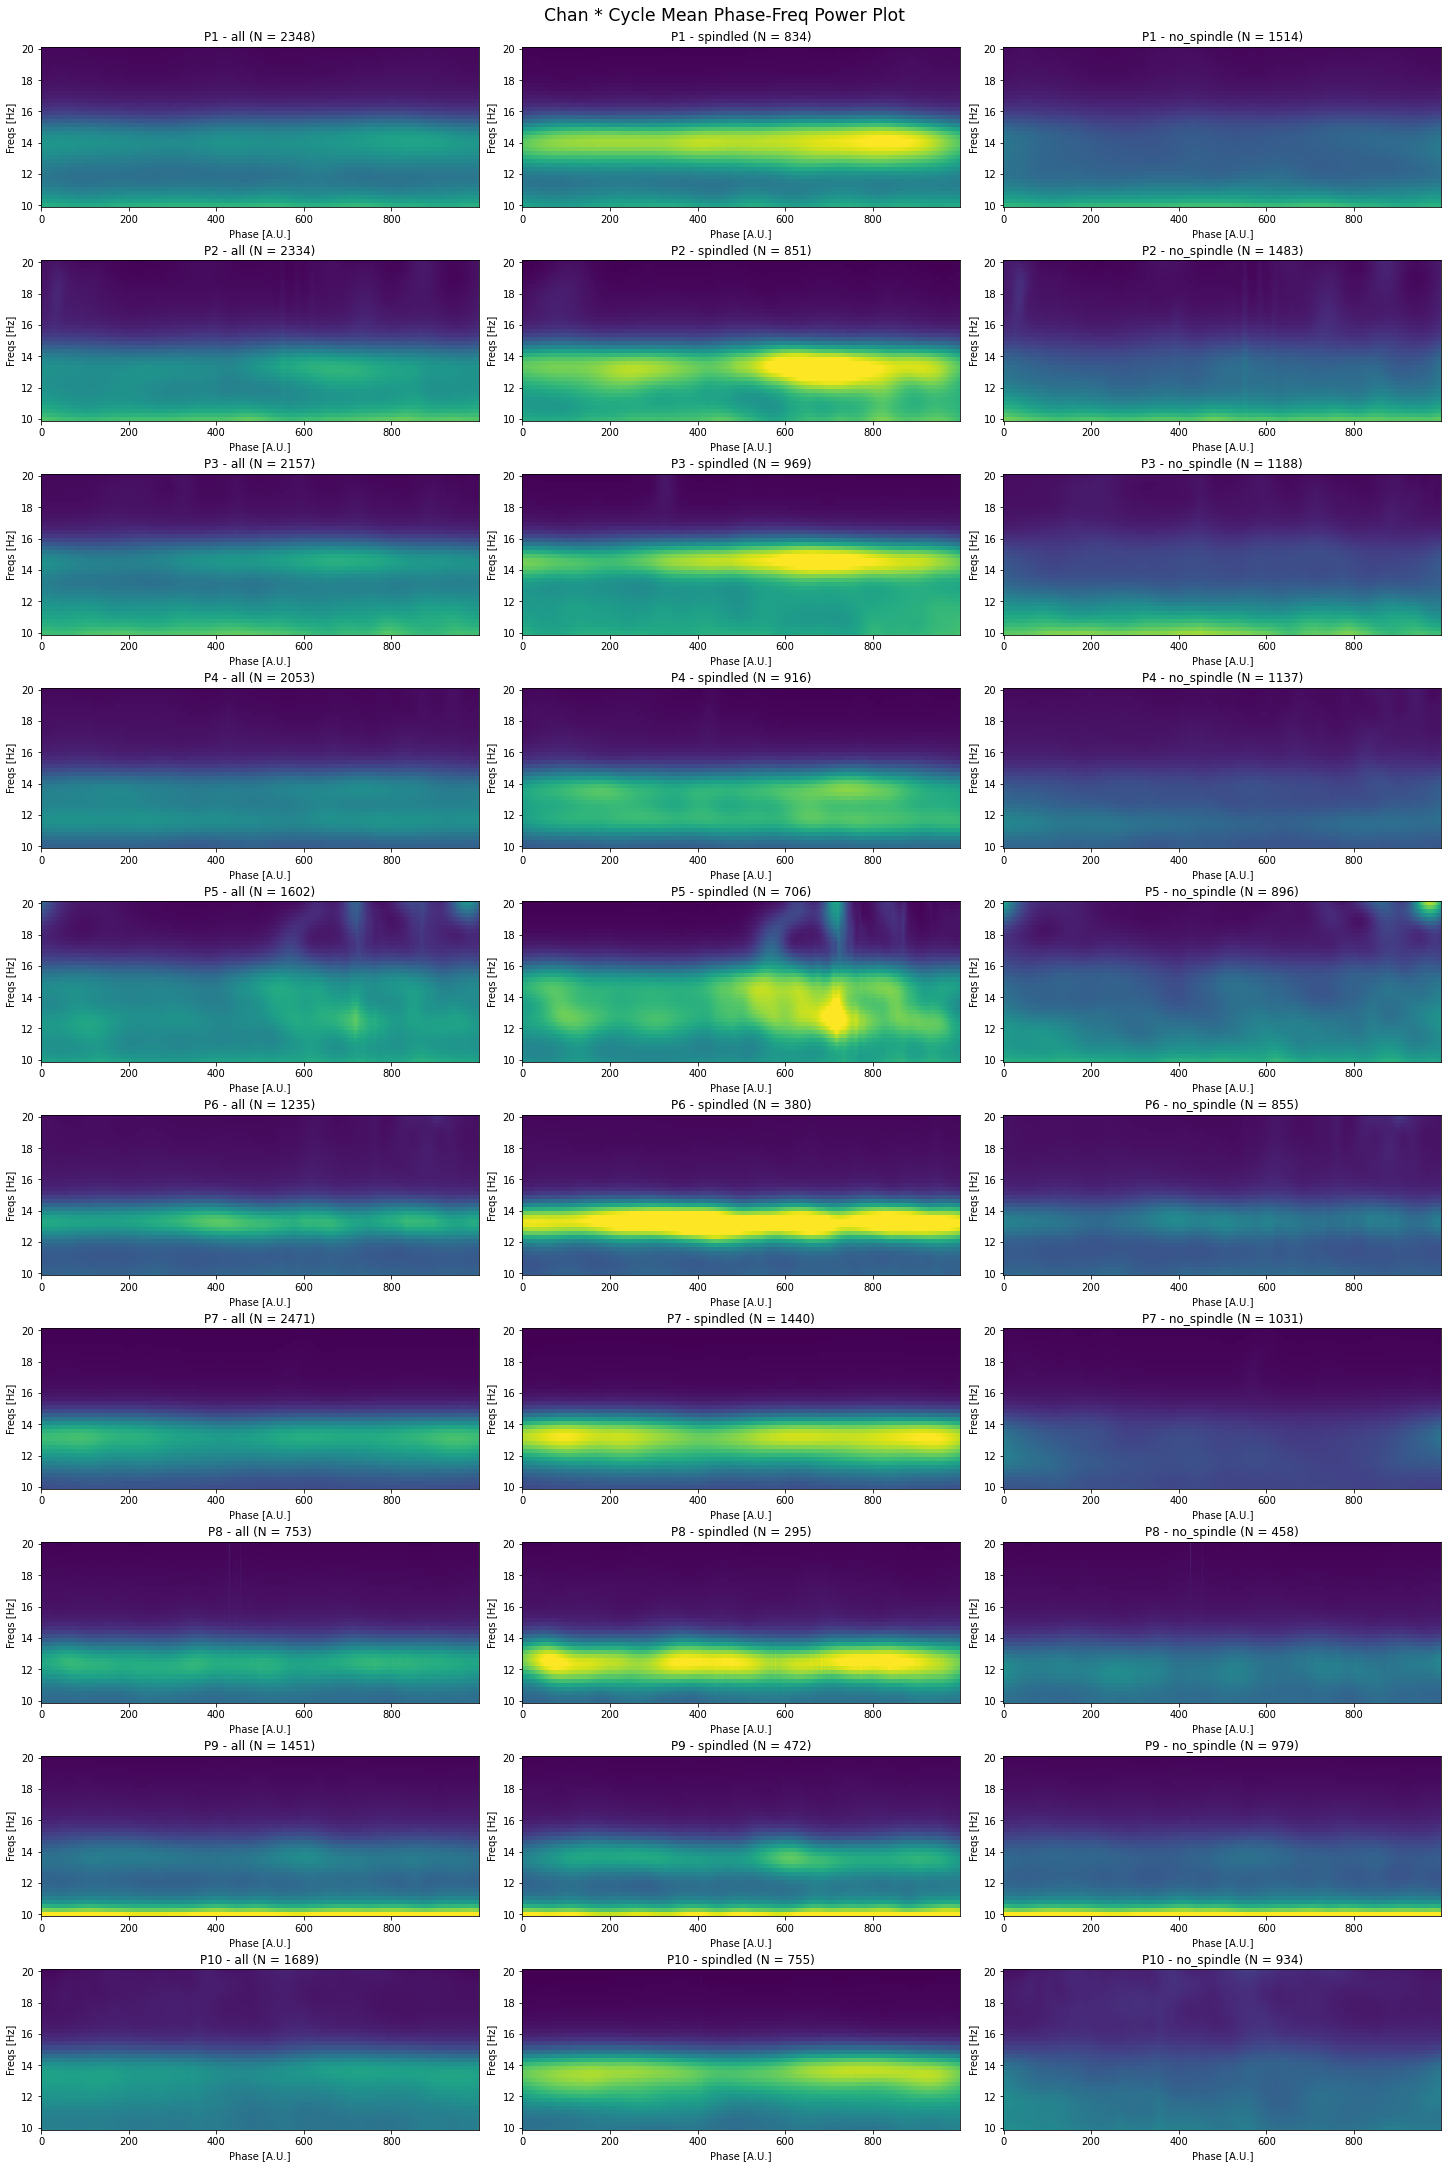

In [66]:
fig , axs = plt.subplots(nrows = len(patients), ncols = tf_all_sel.coords['cycle_sel'].values.size, figsize = (20,30), constrained_layout =True)
fig.suptitle('Chan * Cycle Mean Phase-Freq Power Plot', size = 'xx-large')

x = tf_all_sel.coords['point'].values
y = tf_all_sel.coords['freqs'].values
q = 0.97

for row, patient in enumerate(patients):
    vmin = tf_all_sel.sel(patient=patient).quantile(1-q).values
    vmax = tf_all_sel.sel(patient=patient).quantile(q).values
    for col, mean in enumerate(tf_all_sel.coords['cycle_sel'].values):
        ax = axs[row, col]
        c = tf_all_sel.loc[patient,mean,:,:].mean('chan').values
        ax.pcolormesh(x, y , c, vmin=vmin, vmax=vmax)
        ax.set_title(f'{patient} - {mean} (N = {get_cycles_num(patient,mean)})')
        ax.set_ylabel('Freqs [Hz]')
        ax.set_xlabel('Phase [A.U.]')

if savefig:
    plt.savefig('../presentation_2/mean_phase_freq')
plt.show()

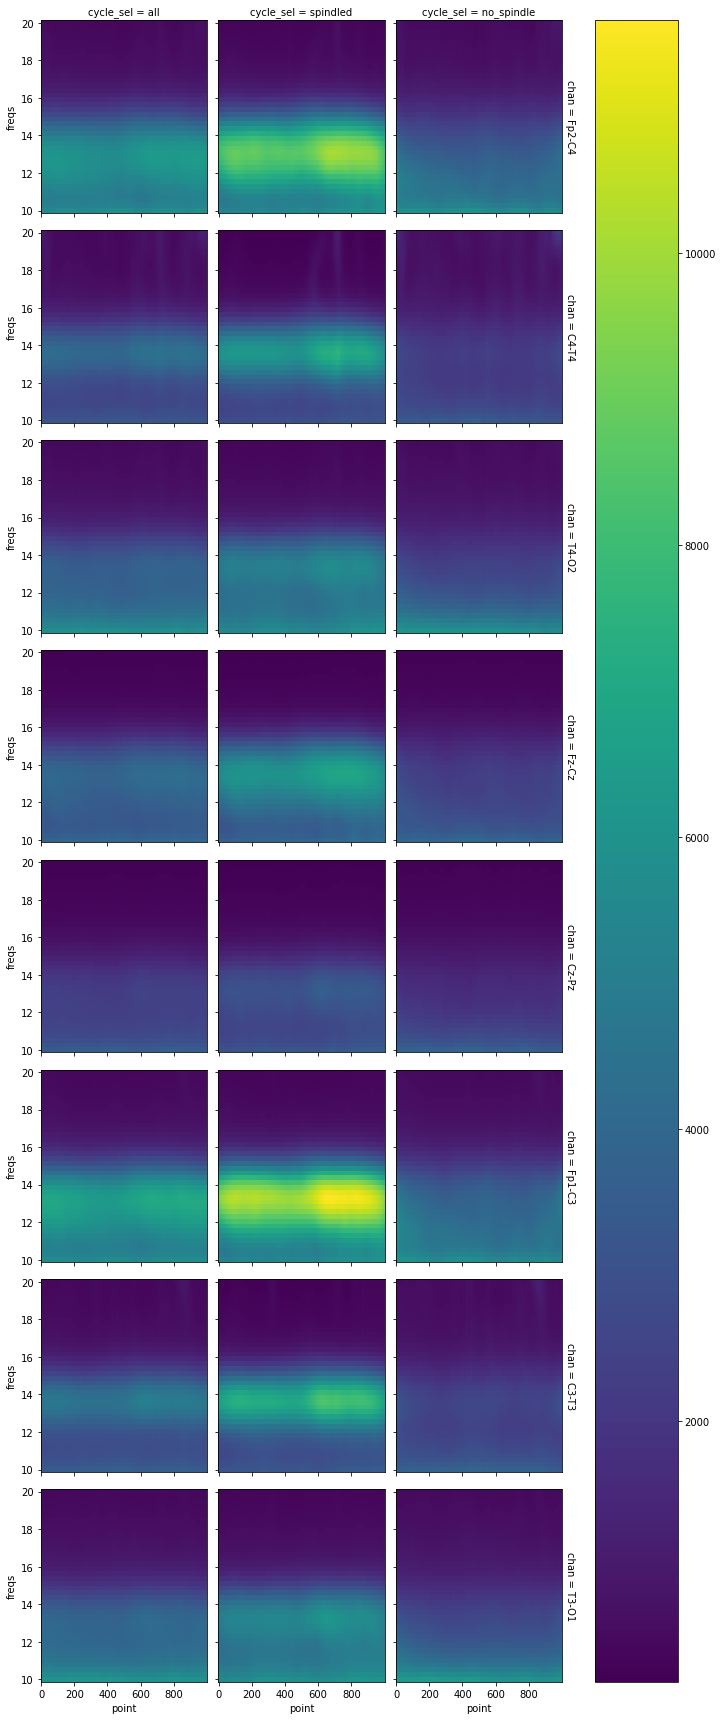

In [69]:
tf_all_sel.mean('patient').plot.pcolormesh(x='point',y='freqs',row = 'chan', col = 'cycle_sel')

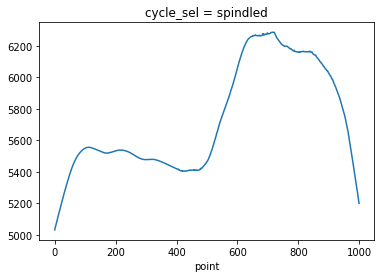

In [85]:
tf_all_sel.loc[:,:,:,12:15,:].mean(['patient','chan']).loc['spindled',:,:].mean('freqs').plot.line(x='point')

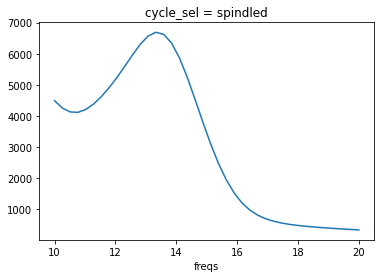

In [78]:
tf_all_sel.mean(['patient','chan','point']).loc['spindled',:].plot()

In [71]:
tf_all_sel.coords['freqs'].loc[12:15]

<xarray.DataArray 'freqs' (freqs: 12)>
array([12.051282, 12.307692, 12.564103, 12.820513, 13.076923, 13.333333,
       13.589744, 13.846154, 14.102564, 14.358974, 14.615385, 14.871795])
Coordinates:
  * freqs    (freqs) float64 12.05 12.31 12.56 12.82 ... 14.1 14.36 14.62 14.87

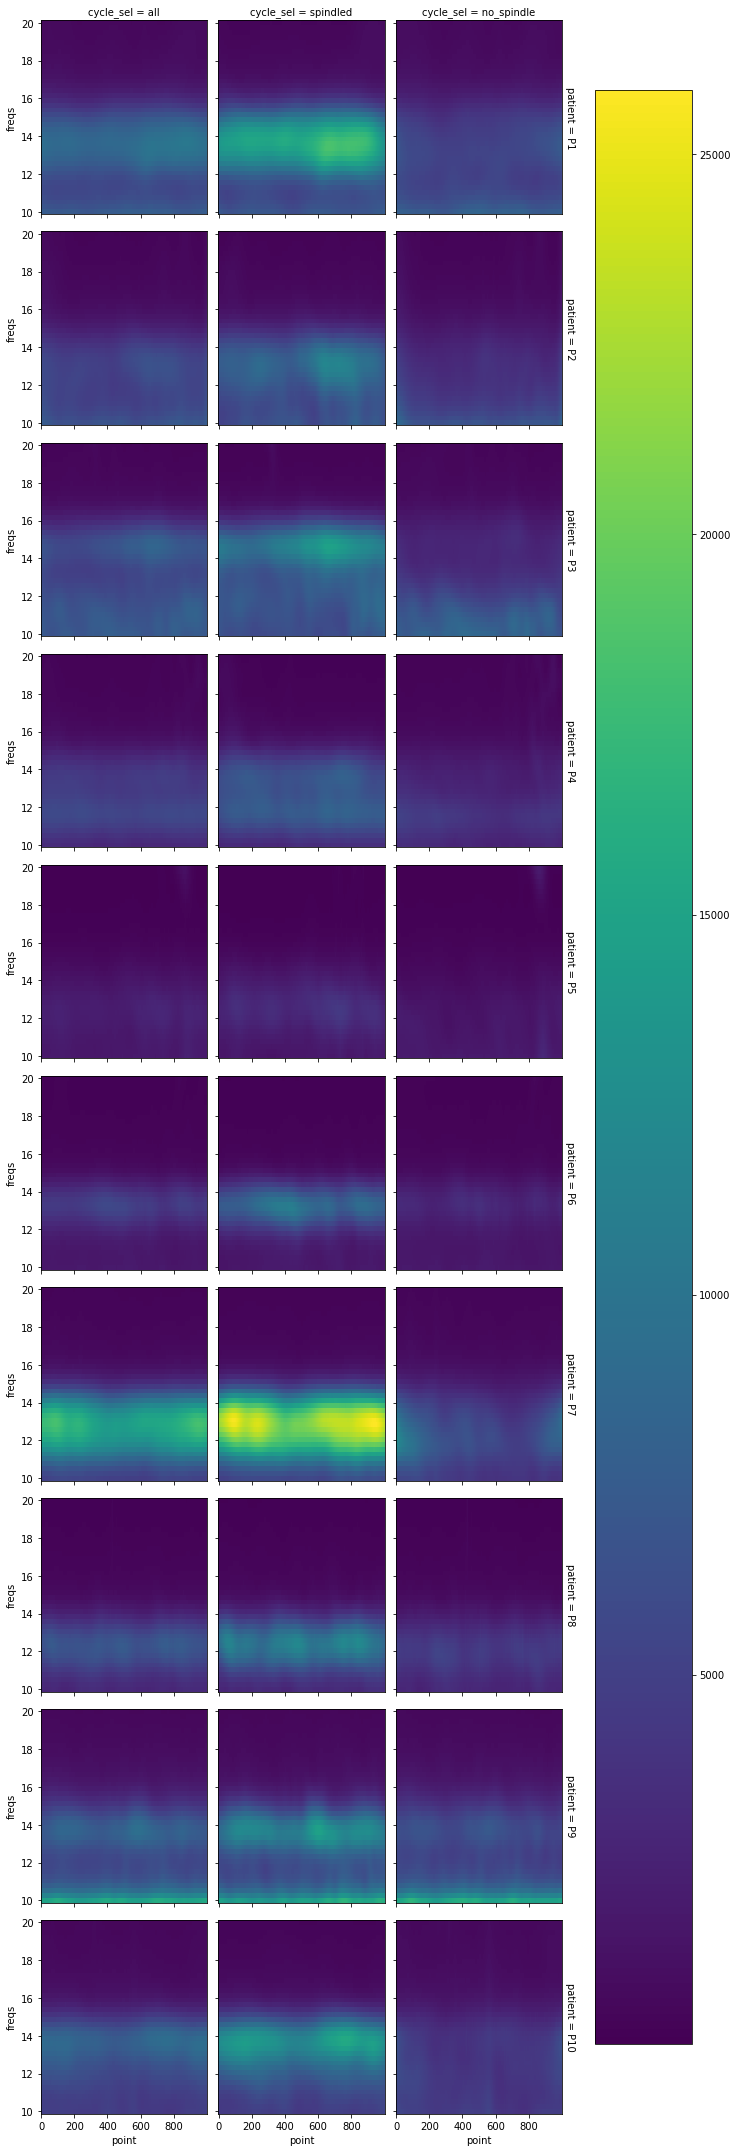

In [95]:
tf_all_sel.loc[:,:,'Fp1-C3',:,:].plot.pcolormesh(x='point',y='freqs',row ='patient', col = 'cycle_sel')